In [2]:
import tensorflow as tf

from functools import partial
import itertools
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Embedding, multiply, LeakyReLU, ReLU, Softmax
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution
disable_eager_execution()
# enable_eager_execution()

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from tensorflow.keras.utils import to_categorical

import warnings
warnings.simplefilter("ignore")

In [2]:
tf.__version__

'2.7.0'

In [3]:
try:
    gpus = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print("Physical GPUs:", len(gpus))
    print("Logical GPUs:", len(logical_gpus))

except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
    
gpus

Physical GPUs: 1
Logical GPUs: 1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Read data


In [279]:
x_train = np.load("../data-preprocessing/data/preserve10/x_train.npy")
y_train = np.load("../data-preprocessing/data/preserve10/y_train.npy")
x_test = np.load("../data-preprocessing/data/preserve10/x_test.npy")
y_test = np.load("../data-preprocessing/data/preserve10/y_test.npy")

In [280]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(214914, 31) (214914, 1) (71638, 31) (71638, 1)


In [283]:
y_test

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [80]:
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pandas as pd

#cleans = pd.read_csv("../data-preprocessing/sampled_cic2018_data.csv")
#cleans = pd.read_csv("../data-preprocessing/data/preserve50/cleans.csv")

def preproc_data(dataset, train_sample: float, pca_dim=31):

    # Label encode
    le = LabelEncoder()
    dataset['label'] = le.fit_transform(dataset['label'])

    # Train test split
    x_train, x_test, y_train, y_test = train_test_split(dataset.iloc[:,:-1],
                                                        dataset['label'],
                                                        test_size=1-train_sample,
                                                        random_state=0)
    # Standard scaling
    ss = StandardScaler().fit(x_train)

    x_train = ss.transform(x_train)
    x_test = ss.transform(x_test)

    # PCA
    pca = PCA(n_components=31).fit(x_train)

    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)

    # Normalization
    norm = Normalizer().fit(x_train)

    x_train = norm.transform(x_train)
    x_test = norm.transform(x_test)

    # Reshaping 
    y_train = y_train.values.reshape(-1,1)
    y_test = y_test.values.reshape(-1,1)
    return x_train, x_test, y_train, y_test, pca, ss, norm

### Model Definition

In [81]:
class RandomWeightedAverage(tf.keras.layers.Layer):
    """Provides a (random) weighted average between real and generated image samples"""
    
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
    
    def call(self, inputs, **kwargs):
        alpha = tf.random.uniform((self.batch_size, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
    
    def compute_output_shape(self, input_shape):
        return input_shape[0]

    
class ECGAN():
    def __init__(self, 
                 x_train, 
                 y_train, 
                 num_classes: int, 
                 latent_dim: int, 
                 batch_size: int,
                 n_critic: int,
                 conf_thresh: float,
                 adv_weight: float):
        """Implement EC-GAN with an WCGAN-GP and MLP.        
        
        Attributes
        ---------
        x_train : numpy.ndarray
            Real data without labels used for training.
            (Created with sklearn.model_selection.train_test_split
        
        y_train : numpy.ndarray
            Real data labels.
            
        num_classes : int
            Number of data classes. Number of unique elements in y_train.
            
        data_dim : int
            Data dimension. Number of columns in x_train.
            
        latent_dim : int
            Dimension of random noise vector (z), used for training
            the generator.
            
        batch_size : int
            Size of training batch in each epoch.
        
        n_critic : int
            Number of times the critic (discriminator) will be trained
            in each epoch.
            
        conf_thresh : float
            Confidence threshold. EC-GAN parameter which decides how good
            the generated sample needs to be, for it to be fed to the 
            classifier.
        
        adv_weight : float
            Adverserial weight. EC-GAN parameter which represents the 
            importance fake data has on classifier training.
            Value has been taken from the original paper.
        
        """
        
        self.x_train = x_train.copy()
        self.y_train = y_train.copy()
        
        # Store labels as one-hot vectors.
        self.y_train_onehot = to_categorical(y_train)
        
        self.num_classes = num_classes
        self.data_dim = x_train.shape[1]
        
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        
        # WCGAN-GP parameters. 
        self.n_critic = n_critic
        
        # EC-GAN parameters.
        self.conf_thresh = conf_thresh
        self.adv_weight = adv_weight
        
        # Log training progress.
        self.losslog = []
        self.class_acc_log = []
        self.class_loss_log = []

        # Adam optimizer for WCGAN-GP, suggested by original paper.
        optimizer = Adam(learning_rate=0.0005, beta_1=0.05, beta_2=0.9)

        # Categorical crossentropy loss function for the classifier.
        self.cce_loss = tf.keras.losses.CategoricalCrossentropy()

        # Build the generator, critic and classifier
        self.generator = self.build_generator()
        self.critic = self.build_critic()
        self.classifier = self.build_classifier()

        
        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic.
        self.generator.trainable = False

        # Data input (real sample).
        real_data = Input(shape=self.data_dim, name="Real_data")
        # Noise input (z).
        noise = Input(shape=(self.latent_dim,), name="Noise")
        # Label input.
        label = Input(shape=(1,), name="Label")
        
        # Generate data based of noise (fake sample)
        fake_data = self.generator([noise, label])
        
        # Critic (discriminator) determines validity of the real and fake images.
        fake = self.critic([fake_data, label])
        valid = self.critic([real_data, label])
        
        # Construct weighted average between real and fake images.
        interpolated_data = RandomWeightedAverage(self.batch_size)([real_data, fake_data])
        
        # Determine validity of weighted sample.
        validity_interpolated = self.critic([interpolated_data, label])
        
        
        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument.
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_data)
        # Keras requires function names.
        partial_gp_loss.__name__ = 'gradient_penalty' 
        
        self.critic_model = Model(
            inputs=[real_data, label, noise],
            outputs=[valid, fake, validity_interpolated]
        )
        
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                        self.wasserstein_loss,
                                        partial_gp_loss],
                                  optimizer=optimizer,
                                  loss_weights=[1, 1, 10])
 
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze other's layers.
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator.
        noise = Input(shape=(self.latent_dim,), name="Noise")
        
        # Add label to input.
        label = Input(shape=(1,), name="Label")
        
        # Generate data based of noise.
        fake_data = self.generator([noise, label])
        
        # Discriminator determines validity.
        valid = self.critic([fake_data, label])

        # Defines generator model.
        self.generator_model = Model([noise, label], valid)
        
        self.generator_model.compile(loss=self.wasserstein_loss, 
                                     optimizer=optimizer)

        
        
        #-------------------------------
        # Construct Computational Graph
        #   for the Classifier (real)
        #-------------------------------
        
        # Real data classifier training
        
        real_data = Input(shape=self.data_dim, name="Real_data")
        
        real_predictions = self.classifier(real_data)
        
        self.real_classifier_model = Model(real_data, real_predictions)
        
        self.real_classifier_model.compile(loss="categorical_crossentropy",
                                           optimizer="adamax",
                                           metrics=["accuracy"])
        
        #-------------------------------
        # Construct Computational Graph
        #   for the Classifier (fake)
        #-------------------------------
        
        # Fake data classifier training
        
        noise = Input(shape=(self.latent_dim,), name="Noise")
        fake_labels = Input(shape=(1,), name="Label")
        
        real_data = Input(shape=self.data_dim, name="Real_data")
        
        fake_data = self.generator([noise, fake_labels])
        
        fake_predictions = self.classifier(fake_data)
        
        self.fake_classifier_model = Model([noise, fake_labels], fake_predictions)
        
        self.fake_classifier_model.compile(loss=self.ecgan_loss, 
                                           optimizer="adamax",
                                           metrics=["accuracy"])

        
        
    def ecgan_loss(self, y_true, y_pred):
        """Calculate loss for fake data predictions."""
        
        max_values = tf.math.reduce_max(y_pred, axis=1)
        
        max_index = tf.where(tf.math.greater(max_values, self.conf_thresh))
        
        loss = self.adv_weight * self.cce_loss(y_true[max_index], y_pred[max_index])
        
        return loss
    

    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential(name="Generator")
        
        # First hidden layer.
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))
        
        # Second hidden layer.
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))
        
        # Third hidden layer.
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))
        
        # Output layer.
        model.add(Dense(self.data_dim, activation="tanh"))
        
        model.summary()
        
        # Noise and label input layers.
        noise = Input(shape=(self.latent_dim,), name="Noise")
        label = Input(shape=(1,), dtype="int32", name="Label")
        
        # Embed labels into onehot encoded vectors.
        label_embedding = Flatten(name="Flatten")(Embedding(self.num_classes, self.latent_dim, name="Embedding")(label))
        
        # Multiply noise and embedded labels to be used as model input.
        model_input = multiply([noise, label_embedding], name="Multiply")
        
        generated_data = model(model_input)

        return Model(inputs=[noise, label], 
                     outputs=generated_data, 
                     name="Generator")

    def build_critic(self):

        model = Sequential(name="Critic")

        # First hidden layer.
        model.add(Dense(1024, input_dim=self.data_dim))
        model.add(LeakyReLU(alpha=0.2))
        
        # Second hidden layer.        
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        
        # Third hidden layer.
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))

        # Output layer with linear activation.
        model.add(Dense(1))

        model.summary()
        
        # Artificial data input.
        generated_sample = Input(shape=self.data_dim, name="Generated_data")
        # Label input.
        label = Input(shape=(1,), dtype="int32", name="Label") 
        
        # Embedd label as onehot vector.
        label_embedding = Flatten(name="Flatten")(Embedding(self.num_classes, self.data_dim, name="Embedding")(label))
        
        # Multiply fake data sample with label embedding to get critic input.
        model_input = multiply([generated_sample, label_embedding], name="Multiply")
        
        validity = model(model_input)

        return Model(inputs=[generated_sample, label], 
                     outputs=validity, 
                     name="Critic")
    
    def build_classifier(self):
        
        model = Sequential(name="Classifier")
        
        # First hidden layer.
        model.add(Dense(128, input_dim=self.data_dim))
        model.add(ReLU())
        model.add(Dropout(0.3))
        
        # Second hidden layer.
        model.add(Dense(256))
        model.add(ReLU())
        model.add(Dropout(0.3))
        
        model.add(Dense(128))
        model.add(ReLU())
        model.add(Dropout(0.3))
        
        # Output layer.
        model.add(Dense(self.num_classes))
        model.add(Softmax())
        
        model.summary()
        
        # Data input.
        data = Input(shape=self.data_dim, name="Data")

        # CLassifier outout is class predictions vector.
        predictions = model(data)
        
        return Model(inputs=data,
                     outputs=predictions,
                     name="Classifier")
        
        
    def train(self, epochs):
        
        self.epochs = epochs

        # Adversarial ground truths.
        valid = -(np.ones((self.batch_size, 1)))
        fake =  np.ones((self.batch_size, 1))
        dummy = np.zeros((self.batch_size, 1))

        # Number of batches.
        self.n_batches = math.floor(self.x_train.shape[0] / self.batch_size)

        overhead = self.x_train.shape[0] % self.batch_size
         
        for epoch in range(epochs):
            
            # Reset training set.
            self.x_train = x_train.copy()
            self.y_train = y_train.copy()

            # Select random overhead rows that do not fit into batches.
            rand_overhead_idx = np.random.choice(range(self.x_train.shape[0]), overhead, replace=False)

            # Remove random overhead rows.
            self.x_train = np.delete(self.x_train, rand_overhead_idx, axis=0)
            self.y_train = np.delete(self.y_train, rand_overhead_idx, axis=0)


            # Split training data into batches.
            x_batches = np.split(self.x_train, self.n_batches)
            y_batches = np.split(self.y_train, self.n_batches)
            
            for x_batch, y_batch, i in zip(x_batches, y_batches, range(self.n_batches)):   
                
                if epoch < 5:
                    
                    for _ in range(self.n_critic):

                        # ---------------------
                        #  Train Critic
                        # ---------------------

                        # Generate random noise.
                        noise = np.random.normal(0, 1, (self.batch_size, self.latent_dim))

                        # Train the critic.
                        d_loss = self.critic_model.train_on_batch(
                            [x_batch, y_batch, noise],                                      
                            [valid, fake, dummy])


                    # ---------------------
                    #  Train Generator
                    # ---------------------

                    # Generate sample of artificial labels.
                    generated_labels = np.random.randint(1, self.num_classes, self.batch_size).reshape(-1, 1)

                    # Train generator.
                    g_loss = self.generator_model.train_on_batch([noise, generated_labels], valid)


                    # ---------------------
                    #  Train Classifier
                    # ---------------------

                    # One-hot encode real labels.
                    y_batch = to_categorical(y_batch, self.num_classes)

                    # One-hot encode generated labels.
                    generated_labels_onehot = to_categorical(generated_labels, self.num_classes)

                    real_loss = self.real_classifier_model.train_on_batch(x_batch, y_batch)

                    fake_loss = self.fake_classifier_model.train_on_batch([noise, generated_labels], generated_labels_onehot)

                    # Classifier loss as presented in EC-GAN paper.
                    c_loss = (real_loss[0] + fake_loss[0]) / (1 + self.adv_weight)

                    avg_acc = np.mean([real_loss[1], fake_loss[1]])
                
                else:
                    
                    # ---------------------
                    #  Train Classifier
                    # ---------------------
                    
                    # Generate random noise.
                    noise = np.random.normal(0, 1, (self.batch_size, self.latent_dim))

                    # Generate sample of artificial labels.
                    generated_labels = np.random.randint(1, self.num_classes, self.batch_size).reshape(-1, 1)

                    # One-hot encode real labels.
                    y_batch = to_categorical(y_batch, self.num_classes)

                    # One-hot encode generated labels.
                    generated_labels_onehot = to_categorical(generated_labels, self.num_classes)

                    real_loss = self.real_classifier_model.train_on_batch(x_batch, y_batch)

                    fake_loss = self.fake_classifier_model.train_on_batch([noise, generated_labels], generated_labels_onehot)

                    # Classifier loss as presented in EC-GAN paper.
                    c_loss = (real_loss[0] + fake_loss[0]) / (1 + self.adv_weight)

                    avg_acc = np.mean([real_loss[1], fake_loss[1]])


                # ---------------------
                #  Logging
                # ---------------------

                self.losslog.append([d_loss[0], g_loss, c_loss])
                self.class_loss_log.append([real_loss[0], fake_loss[0], c_loss])
                self.class_acc_log.append([real_loss[1], fake_loss[1], avg_acc])

                # Plot progress.
                # Plot progress.
                DLOSS = "%.4f" % d_loss[0]
                GLOSS = "%.4f" % g_loss
                CLOSS = "%.4f" % c_loss
                RLOSS = "%.4f" % real_loss[0]
                FLOSS = "%.4f" % fake_loss[0]
                CACC  = "%.4f" % real_loss[1]
                
                if i % 100 == 0:
                    print (f"{epoch} - {i}/{self.n_batches} \t [D loss: {DLOSS}] [G loss: {GLOSS}] [R loss: {RLOSS} | F loss: {FLOSS} | C loss: {CLOSS} - C acc: {CACC}]")


In [259]:
gan = ECGAN(x_train,
            y_train,
            num_classes=15,
            latent_dim=32,
            batch_size=128,
            n_critic=5,
            conf_thresh=.2,
            adv_weight=.1
            )

gan.train(epochs=10)

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_172 (Dense)           (None, 256)               8448      
                                                                 
 leaky_re_lu_87 (LeakyReLU)  (None, 256)               0         
                                                                 
 dropout_87 (Dropout)        (None, 256)               0         
                                                                 
 dense_173 (Dense)           (None, 512)               131584    
                                                                 
 leaky_re_lu_88 (LeakyReLU)  (None, 512)               0         
                                                                 
 dropout_88 (Dropout)        (None, 512)               0         
                                                                 
 dense_174 (Dense)           (None, 1024)              52

In [260]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    mode='max',
    patience=5,
    min_delta=0.0001
)

In [261]:
num_samples = 50000  # 생성할 데이터 샘플 수
noise = np.random.normal(0, 1, (num_samples, gan.latent_dim))  # 넘파이 배열로 노이즈 생성
labels = np.random.randint(0, gan.num_classes, num_samples).reshape(-1, 1)  # 넘파이 배열로 라벨 생성
# Defines generator model.
gen_mo = gan.generator

print(noise.shape)

# 모델을 사용하여 가짜 데이터 생성
generated_data = gen_mo.predict([noise, labels])

# 결과 출력
print(generated_data.shape)  

(50000, 32)
(50000, 31)


In [265]:
# Classifier를 사용하여 생성된 데이터의 라벨을 예측
predicted_labels = gan.classifier.predict(generated_data)

# 예측된 라벨 확인
predicted_labels_class = np.argmax(predicted_labels, axis=1)  # 라벨을 one-hot에서 원래 라벨로 변환
print(f"Predicted labels: {predicted_labels_class}")


Predicted labels: [11  9 10 ...  2 10  7]


In [266]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
# 3. 성능 평가 - Accuracy, F1-Score, Precision, Recall

# 라벨을 원래 라벨 형식으로 변환 (실제 라벨과 비교)
true_labels = labels.flatten()  # 라벨의 차원 축소 (1D로 변환)

# Accuracy 계산
accuracy = accuracy_score(true_labels, predicted_labels_class)

# F1-Score 계산
f1 = f1_score(true_labels, predicted_labels_class, average='weighted')

# Precision 계산
precision = precision_score(true_labels, predicted_labels_class, average='weighted')

# Recall 계산
recall = recall_score(true_labels, predicted_labels_class, average='weighted')

conf_matrix = confusion_matrix(true_labels, predicted_labels_class)
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  # False Positives
TN = conf_matrix.sum() - (FP + conf_matrix.sum(axis=1) - np.diag(conf_matrix))  # True Negatives
FAR = FP / (FP + TN)

# 성능 지표 출력
print(f"False Alarm Rate (FAR): {np.mean(FAR)}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")

False Alarm Rate (FAR): 0.004474666666666667
Accuracy: 0.9329
F1-Score: 0.9097
Precision: 0.9641


In [205]:
from experiments.predictions import make_prediction, PredMetrics, get_prediction_metrics, labels
from tensorflow.keras.models import load_model
pred_lbl = predicted_labels_class.reshape(-1, 1)


n_generator = load_model('../models/10_classifier_standalone.h5')
n_generator.compile(optimizer='adam', loss='binary_crossentropy')

#predictions = make_prediction(gan.c, pd.DataFrame(generated_data), pd.DataFrame(pred_lbl))
predictions = make_prediction(n_generator, pd.DataFrame(generated_data), pd.DataFrame(pred_lbl))
pred_metrics = get_prediction_metrics(predictions)


data Generator

In [142]:
import tensorflow as tf
from tensorflow.keras.models import load_model

In [7]:
n_generator = load_model('../models/10_generator_ecgan.h5')

In [8]:
n_generator.compile(optimizer='adam', loss='binary_crossentropy')

In [31]:
latent_dim = 32  # GAN에서 사용된 latent_dim에 맞춰 조정
num_samples = 50000  # 생성할 가짜 데이터 샘플 수
num_class = 15 # 공격 유형 종류 개수

n_noise = np.random.normal(0, 1, (num_samples, latent_dim))
n_labels = np.random.randint(0, num_class, num_samples).reshape(-1, 1)

n_generated_data = n_generator.predict([n_noise, n_labels])


print("Generated Data:")
print(n_generated_data)

Generated Data:
[[-0.68268234  0.17495912  0.20577762 ... -0.18258724 -0.18722193
   0.01443134]
 [-0.79286534 -0.11340783 -0.31293982 ...  0.05823324 -0.18581195
   0.3014445 ]
 [-0.4163572  -0.03150876 -0.10934426 ... -0.02998968 -0.2822905
   0.01190818]
 ...
 [ 0.20412876 -0.19480619 -0.7785817  ... -0.06264126 -0.127092
   0.2526062 ]
 [-0.71806127 -0.09468994  0.21338812 ... -0.13885799 -0.45534924
  -0.3653347 ]
 [-0.04258306 -0.043513   -0.82570744 ... -0.13206884 -0.61264884
  -0.27819312]]


FID score

In [32]:
n_generated_data.shape
n_generated_data

array([[-0.68268234,  0.17495912,  0.20577762, ..., -0.18258724,
        -0.18722193,  0.01443134],
       [-0.79286534, -0.11340783, -0.31293982, ...,  0.05823324,
        -0.18581195,  0.3014445 ],
       [-0.4163572 , -0.03150876, -0.10934426, ..., -0.02998968,
        -0.2822905 ,  0.01190818],
       ...,
       [ 0.20412876, -0.19480619, -0.7785817 , ..., -0.06264126,
        -0.127092  ,  0.2526062 ],
       [-0.71806127, -0.09468994,  0.21338812, ..., -0.13885799,
        -0.45534924, -0.3653347 ],
       [-0.04258306, -0.043513  , -0.82570744, ..., -0.13206884,
        -0.61264884, -0.27819312]], dtype=float32)

In [277]:
generator = load_model('../models/10_generator_ecgan.h5')

generator.compile(optimizer='adamax', loss='categorical_crossentropy')

In [278]:
generator.x_train

AttributeError: 'Functional' object has no attribute 'x_train'

In [33]:
# real_data = Input(shape=gan_4.data_dim, name="Real_data")
real_data = gan.x_train
print(real_data.shape)
real_data

(214912, 31)


array([[ 1.85775220e-01,  1.18859810e-01, -2.33336013e-01, ...,
         1.42831494e-03, -1.49054324e-01, -3.82786162e-02],
       [-3.49671383e-01, -1.19709206e-02, -1.96306732e-02, ...,
        -1.09954130e-02,  5.84614070e-02, -3.87464246e-01],
       [-4.20425564e-01, -9.41638142e-03,  9.02171118e-02, ...,
         2.76713237e-03, -1.50640826e-01, -3.32339831e-02],
       ...,
       [-6.07627877e-01, -1.64936326e-02,  4.88910680e-02, ...,
        -1.89801871e-03, -7.00946179e-03,  3.23437019e-02],
       [ 5.13103114e-01,  1.94842904e-02, -6.77089951e-01, ...,
        -5.40587256e-04, -2.47992226e-02,  1.16792042e-01],
       [ 4.99980194e-01,  5.12125608e-02,  1.35006774e-01, ...,
        -1.52033428e-02, -7.36446875e-02, -5.18328094e-02]])

In [274]:
gan

In [256]:
import numpy as np
from scipy.linalg import sqrtm

# FID 계산 함수
def calculate_fid(real_data, generated_data):
    # 평균과 공분산 계산
    mu1, sigma1 = np.mean(real_data, axis=0), np.cov(real_data, rowvar=False)
    mu2, sigma2 = np.mean(generated_data, axis=0), np.cov(generated_data, rowvar=False)

    # 평균 차이 제곱합 계산
    ssdiff = np.sum((mu1 - mu2)**2)

    # 공분산 행렬의 곱의 제곱근 계산
    covmean = sqrtm(sigma1.dot(sigma2))

    # 공분산 행렬에 복소수 값이 발생하는 경우 실수로 변환
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Fréchet Distance 계산
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid


In [273]:
from sklearn.preprocessing import MinMaxScaler
# 데이터 정규화 (0과 1 사이로 변환)
scaler = MinMaxScaler(feature_range=(0, 1))

# 실제 데이터 정규화
x_train_scaled = scaler.fit_transform(gan.x_train)

generated_data_scaled = scaler.transform(generated_data)
norm = Normalizer().fit(x_train_scaled)

x_train_scaled\
    = norm.transform(x_train_scaled)
generated_data_scaled = norm.transform(generated_data_scaled)

# FID 계산
real_data = x_train_scaled
fid_score = calculate_fid(generated_data_scaled, np.array(real_data))
print(f"FID Score: {fid_score}")

FID Score: 0.23649834826424593


In [269]:
# FID 계산
real_data = gan.x_train
fid_score = calculate_fid(generated_data, np.array(real_data))
print(f"FID Score: {fid_score}")

FID Score: 3.21723348627425


In [57]:
np.save("./gen_x_test.npy", generated_data)
np.save("./gen_y_test.npy", labels)

np.save("./n_gen_x_test.npy", n_generated_data)
np.save("./n_gen_y_test.npy", n_labels)


In [70]:
n_generator = load_model('../models/10_generator_ecgan.h5')

ValueError: autodetected range of [nan, nan] is not finite

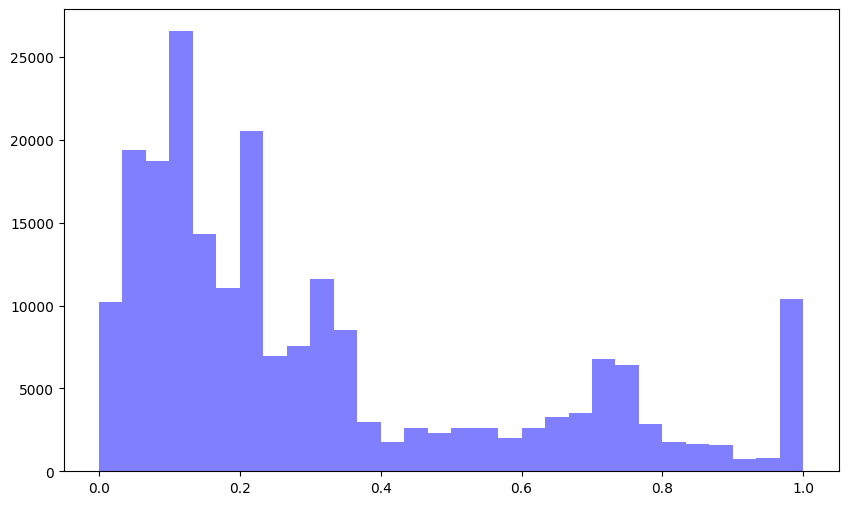

In [258]:
import numpy as np
import matplotlib.pyplot as plt

# 1. real_data와 generated_data 예시 생성
# real_data = np.random.randn(real_data, 31)   # 실제 데이터
# generated_data = np.random.randn(generated_data, 31)  # 생성된 데이터

# 2. 특정 피처 선택 (예: 첫 번째 피처 0번)
real_feature = real_data[:, 0]
generated_feature = generated_data[:, 0]

# 3. 히스토그램으로 분포 시각화
plt.figure(figsize=(10, 6))

# 실제 데이터 히스토그램 (파란색)
plt.hist(real_feature, bins=30, alpha=0.5, label="Real Data", color='blue')

# 생성된 데이터 히스토그램 (빨간색)
plt.hist(generated_feature, bins=30, alpha=0.5, label="Generated Data", color='red')

# 그래프 세부 설정
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.title("Feature 0 Distribution (Real vs Generated Data)")
plt.legend()
plt.show()


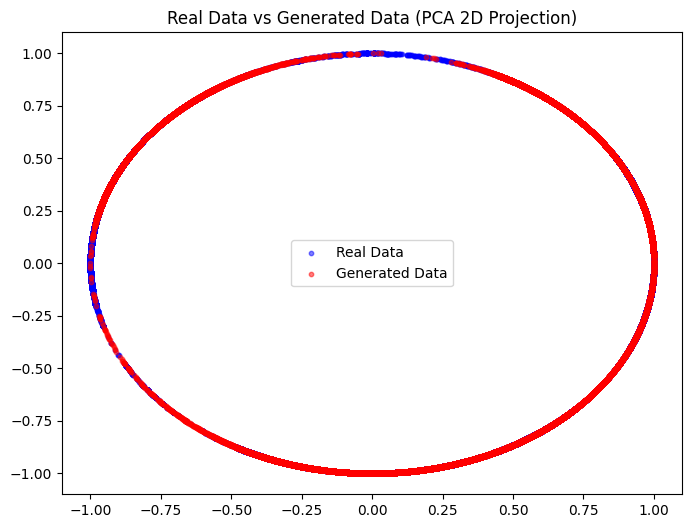

In [271]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. real_data와 generated_data 예시 생성
#real_data = np.random.randn(411136, 31)   # 실제 데이터
#generated_data = np.random.randn(10000, 31)  # 생성된 데이터

# 2. PCA로 2차원으로 차원 축소
pca = PCA(n_components=2)
real_data_2d = pca.fit_transform(real_data)
generated_data_2d = pca.transform(generated_data)

norm = Normalizer().fit(real_data_2d)

real_data_2d = norm.transform(real_data_2d)
generated_data_2d = norm.transform(generated_data_2d)

# 3. 시각화
plt.figure(figsize=(8, 6))

# 실제 데이터 점으로 표시 (파란색)
plt.scatter(real_data_2d[:, 0], real_data_2d[:, 1], label="Real Data", alpha=0.5, c='blue', s=10)

# 생성된 데이터 점으로 표시 (빨간색)
plt.scatter(generated_data_2d[:, 0], generated_data_2d[:, 1], label="Generated Data", alpha=0.5, c='red', s=10)

# 제목 및 범례 추가
plt.title("Real Data vs Generated Data (PCA 2D Projection)")
plt.legend()
plt.show()
